In [2]:
# random forest classifier
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# classification report

from sklearn.metrics import classification_report

import matplotlib.pyplot as plt


# f1, precision, recall, weighted accuracy
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    make_scorer,
    balanced_accuracy_score,
)

# xgboost classifier

from xgboost import XGBClassifier

# lightgbm classifier

from lightgbm import LGBMClassifier

# catboost classifier

from catboost import CatBoostClassifier

import pandas as pd

# Adaboot classifier
from sklearn.ensemble import AdaBoostClassifier

# SVM

from sklearn.svm import SVC

# KNN

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

In [21]:
RAW_DIR = "data/raw"
PROCESSED_DIR = "data/processed"

In [22]:
dataset = pd.read_csv(f"{RAW_DIR}/fetal_health.csv")

## Removing histogram features 
'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',

In [23]:
# Remove columns that have histogram data

dataset = dataset.drop(columns=['histogram_width',
                                'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
                                'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
                                'histogram_median', 'histogram_variance', 'histogram_tendency'])

In [24]:
dataset.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'fetal_health'],
      dtype='object')

In [7]:
label2class = {
    1: "Normal",
    2: "Suspect",
    3: "Pathology"
}

labeel2class_encoded = {
    0: "Normal",
    1: "Suspect",
    2: "Pathology"
}

In [8]:
# split (train, test) stratified and save into processed directory

train, test = train_test_split(
    dataset, test_size=0.5, stratify=dataset["fetal_health"], random_state=42
)

train.to_csv(f"{PROCESSED_DIR}/train.csv", index=False)

test.to_csv(f"{PROCESSED_DIR}/test.csv", index=False)

In [9]:
x_train = train.drop("fetal_health", axis=1)
y_train = train["fetal_health"]

y_train = LabelEncoder().fit_transform(y_train)

In [10]:
x_test = test.drop("fetal_health", axis=1)

y_test = test["fetal_health"]

y_test = LabelEncoder().fit_transform(y_test)

In [11]:
x_train.shape, y_train.shape

((1063, 21), (1063,))

In [81]:
np.bincount(y_train)

array([827, 148,  88])

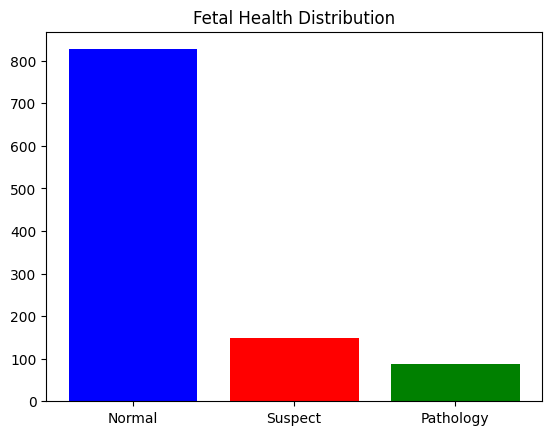

In [80]:
# plot y_train label distribution

plt.bar(
    x=label2class.values(),
    height=np.bincount(y_train),
    color=["blue", "red", "green"],
)

plt.title("Fetal Health Distribution")

plt.show()

In [142]:
models = [
    ("Random Forest", RandomForestClassifier()),
    ("XGBoost", XGBClassifier()),
    ("LightGBM", LGBMClassifier(verbosity=-1)),
    ("CatBoost", CatBoostClassifier(logging_level="Silent")),
    ("AdaBoost", AdaBoostClassifier()),
]

In [33]:
FOLDS = 10

In [143]:
# Define the models and their corresponding parameter grids
models_params = {
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [10, 20, 30],
            "min_samples_split": [2, 5, 10]
        }
    },
    "XGBoost": {
        "model": XGBClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [3, 6, 9],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "LightGBM": {
        "model": LGBMClassifier(verbosity=-1),
        "params": {
            "num_leaves": [31, 62, 128],
            "max_depth": [10, 20, 30],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "CatBoost": {
        "model": CatBoostClassifier(logging_level="Silent"),
        "params": {
            "iterations": [100, 200, 300],
            "depth": [4, 6, 10],
            "learning_rate": [0.01, 0.1, 0.3]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.1, 1.0],
        }
    }
}

### With Histogram

In [39]:
# remove warnings
import warnings

warnings.filterwarnings("ignore")

In [145]:
# Apply GridSearchCV for each model
best_estimators = {}
for model_name, mp in models_params.items():
    print(f"Running GridSearchCV for {model_name}")
    grid_search = GridSearchCV(
        mp['model'], mp['params'], cv=FOLDS, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(x_train,
                    y_train)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Running GridSearchCV for Random Forest
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best score for Random Forest: 0.9349158443699167
Running GridSearchCV for XGBoost
Best parameters for XGBoost: {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200}
Best score for XGBoost: 0.9399151626432072
Running GridSearchCV for LightGBM


KeyboardInterrupt: 

In [ ]:
print(best_estimators)

{'Random Forest': RandomForestClassifier(max_depth=30, min_samples_split=5), 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...), 'LightGBM': LGBMClassifier(max_depth=30, num_leaves=128, verbosity=-1), 'CatBoost': <catboost.core.CatBoostClassifier object at 0x7420cd157100>, 'Ada

## Tests

In [ ]:
from sklearn.ensemble import VotingClassifier

# Create a list of tuples (classifier name, classifier object)
classifiers = [
    ("Random Forest", best_estimators["Random Forest"]),
    ("XGBoost", best_estimators["XGBoost"]),
    ("LightGBM", best_estimators["LightGBM"]),

]



In [ ]:
trained_classifiers = {}
for clf_name, clf in classifiers:
    clf.fit(x_train, y_train)
    trained_classifiers[clf_name] = clf

# Create a voting classifier
voting_clf = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the voting classifier

voting_clf.fit(x_train, y_train)

# Predict the test set

y_pred = voting_clf.predict(x_test)


Learning rate set to 0.079374
0:	learn: 0.9954144	total: 1.37ms	remaining: 1.37s
1:	learn: 0.9126645	total: 2.67ms	remaining: 1.33s
2:	learn: 0.8471595	total: 3.93ms	remaining: 1.31s
3:	learn: 0.7855607	total: 6.19ms	remaining: 1.54s
4:	learn: 0.7352674	total: 7.44ms	remaining: 1.48s
5:	learn: 0.6908722	total: 8.22ms	remaining: 1.36s
6:	learn: 0.6504857	total: 9.44ms	remaining: 1.34s
7:	learn: 0.6208027	total: 11.7ms	remaining: 1.45s
8:	learn: 0.5915907	total: 13ms	remaining: 1.43s
9:	learn: 0.5674152	total: 14.1ms	remaining: 1.4s
10:	learn: 0.5424013	total: 15.2ms	remaining: 1.37s
11:	learn: 0.5187455	total: 16.4ms	remaining: 1.35s
12:	learn: 0.4989901	total: 17.9ms	remaining: 1.36s
13:	learn: 0.4761212	total: 19.4ms	remaining: 1.37s
14:	learn: 0.4589594	total: 20.7ms	remaining: 1.36s
15:	learn: 0.4420664	total: 22ms	remaining: 1.35s
16:	learn: 0.4259963	total: 23.8ms	remaining: 1.37s
17:	learn: 0.4113278	total: 25.3ms	remaining: 1.38s
18:	learn: 0.3960866	total: 26.8ms	remaining: 1.3

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       828
           1       0.81      0.77      0.79       147
           2       0.95      0.88      0.91        88

    accuracy                           0.94      1063
   macro avg       0.91      0.87      0.89      1063
weighted avg       0.94      0.94      0.94      1063



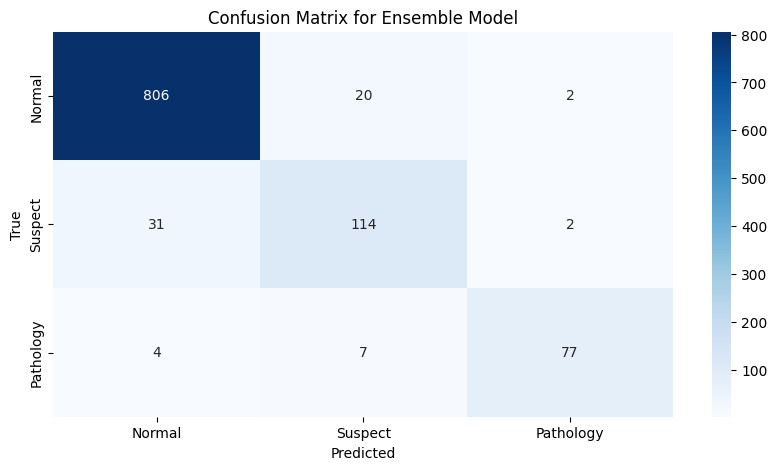

In [ ]:
# matrix confusion
import seaborn as sns
from sklearn.metrics import confusion_matrix

c = confusion_matrix(y_test, y_pred)

# plot

plt.figure(figsize=(10, 5))

sns.heatmap(c, annot=True, fmt="d", cmap="Blues",
            xticklabels=[label2class[i] for i in range(1, 4)],
            yticklabels=[label2class[i] for i in range(1, 4)])

plt.title(f"Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.show()

In [110]:
# smote
from imblearn.over_sampling import ADASYN

In [ ]:

smote = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)


In [ ]:
trained_classifiers_unb = {}
for clf_name, clf in classifiers:
    clf.fit(X_train_resampled, y_train_resampled)
    trained_classifiers[clf_name] = clf

# Create a voting classifier
voting_clf_unb = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the voting classifier

voting_clf_unb.fit(X_train_resampled, y_train_resampled)

# Predict the test set

y_pred_unb = voting_clf.predict(x_test_scaled)


Learning rate set to 0.082919
0:	learn: 1.0078870	total: 4.2ms	remaining: 4.19s
1:	learn: 0.9240818	total: 7.83ms	remaining: 3.91s
2:	learn: 0.8607941	total: 13.6ms	remaining: 4.53s
3:	learn: 0.8066809	total: 18.7ms	remaining: 4.66s
4:	learn: 0.7602683	total: 22.6ms	remaining: 4.51s
5:	learn: 0.7200507	total: 26ms	remaining: 4.31s
6:	learn: 0.6849783	total: 32.3ms	remaining: 4.58s
7:	learn: 0.6525699	total: 37.3ms	remaining: 4.62s
8:	learn: 0.6185783	total: 41.8ms	remaining: 4.61s
9:	learn: 0.5927177	total: 47.4ms	remaining: 4.69s
10:	learn: 0.5663252	total: 52.1ms	remaining: 4.69s
11:	learn: 0.5415983	total: 56.2ms	remaining: 4.62s
12:	learn: 0.5181184	total: 62.9ms	remaining: 4.78s
13:	learn: 0.4978271	total: 68.8ms	remaining: 4.85s
14:	learn: 0.4783839	total: 73.8ms	remaining: 4.84s
15:	learn: 0.4606700	total: 82.5ms	remaining: 5.07s
16:	learn: 0.4432836	total: 89.1ms	remaining: 5.15s
17:	learn: 0.4283129	total: 94.9ms	remaining: 5.18s
18:	learn: 0.4125295	total: 99.7ms	remaining: 5

In [ ]:
print(classification_report(y_test, y_pred_unb))


              precision    recall  f1-score   support

           0       0.99      0.91      0.95       828
           1       0.64      0.93      0.76       147
           2       0.90      0.92      0.91        88

    accuracy                           0.91      1063
   macro avg       0.84      0.92      0.87      1063
weighted avg       0.94      0.91      0.92      1063



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       828
           1       0.81      0.78      0.79       147
           2       0.95      0.88      0.91        88

    accuracy                           0.94      1063
   macro avg       0.91      0.87      0.89      1063
weighted avg       0.94      0.94      0.94      1063



In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

In [ ]:
# Apply BorderlineSMOTE

smote = BorderlineSMOTE(random_state=42)

X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

trained_classifiers_unb = {}
for clf_name, clf in classifiers:
    clf.fit(X_train_resampled, y_train_resampled)
    trained_classifiers[clf_name] = clf

# Create a voting classifier
voting_clf_unb = VotingClassifier(estimators=classifiers, voting='soft')

# Fit the voting classifier

voting_clf_unb.fit(X_train_resampled, y_train_resampled)

# Predict the test set

y_pred_unb = voting_clf.predict(x_test)


print(classification_report(y_test, y_pred_unb))



Learning rate set to 0.08288
0:	learn: 1.0091617	total: 6.2ms	remaining: 6.19s
1:	learn: 0.9287020	total: 11.8ms	remaining: 5.91s
2:	learn: 0.8719684	total: 18.5ms	remaining: 6.13s
3:	learn: 0.8138167	total: 26.3ms	remaining: 6.55s
4:	learn: 0.7656962	total: 33.4ms	remaining: 6.65s
5:	learn: 0.7221709	total: 36.9ms	remaining: 6.12s
6:	learn: 0.6827067	total: 42.9ms	remaining: 6.08s
7:	learn: 0.6520061	total: 48.9ms	remaining: 6.06s
8:	learn: 0.6193988	total: 54ms	remaining: 5.95s
9:	learn: 0.5926373	total: 60.2ms	remaining: 5.96s
10:	learn: 0.5651373	total: 66.2ms	remaining: 5.95s
11:	learn: 0.5369845	total: 72.3ms	remaining: 5.95s
12:	learn: 0.5104095	total: 76.6ms	remaining: 5.82s
13:	learn: 0.4884877	total: 81.3ms	remaining: 5.73s
14:	learn: 0.4692587	total: 87.1ms	remaining: 5.72s
15:	learn: 0.4477772	total: 91.6ms	remaining: 5.63s
16:	learn: 0.4301559	total: 98.1ms	remaining: 5.67s
17:	learn: 0.4162163	total: 102ms	remaining: 5.55s
18:	learn: 0.3994567	total: 108ms	remaining: 5.59

In [ ]:
print(classification_report(y_test, y_pred_unb))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       828
           1       0.64      0.93      0.76       147
           2       0.90      0.92      0.91        88

    accuracy                           0.91      1063
   macro avg       0.84      0.92      0.87      1063
weighted avg       0.94      0.91      0.92      1063



In [141]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       828
           1       0.81      0.77      0.79       147
           2       0.95      0.88      0.91        88

    accuracy                           0.94      1063
   macro avg       0.91      0.87      0.89      1063
weighted avg       0.94      0.94      0.94      1063

